In [19]:
n_epochs = 25
learning_rate = 0.001
batch_size=64

In [20]:
## Libaries
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import time
from datetime import datetime
time_date = datetime.now()
date = time_date.strftime("%d/%m/%Y")
Time = time_date.strftime("%H:%M:%S")
import numpy as np


In [21]:
# Download the Data and transformations
print('==> Preparing data..')

transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


## Downloading training data
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

## Downloading test data
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

## Class labels
classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [22]:
## Model
print('==> Building model..')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=False, num_classes=10)
net = net.to(device)

==> Building model..


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [23]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
## Loss
criterion = nn.CrossEntropyLoss()

## Optimizer using (SGD)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [25]:

## Validation 
def calculate_accuracy(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)

    return correct*100./total

In [26]:
def train():
    print("---------------------------------------------------")
    print("Model Training and Testing Start date:", date)
    print("Model Training and Testing starting time:", Time)
    print("---------------------------------------------------")
    print('Resnet Training and Testing Begins!')
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    max_accuracy=0
    EPOCH = n_epochs
    train_accuracies = []
    validation_accuracies = []
    
    train_losses = []
    validation_losses = []
    
    for epoch in range(EPOCH):
        ep_start = time.time()
        ## training loop
        train_loss = 0
        for i, (images,labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_item = loss.item()
            train_loss += loss_item * images.size(0)
            loss.backward()
            optimizer.step()


        ## validation loop
        valid_loss = 0.0
        net.eval()     # Optional when not using Model Specific layer
        for data, labels in testloader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            
            target = net(data)
            loss = criterion(target,labels)
            valid_loss += loss.item() * data.size(0)

        train_losses.append(train_loss)  
        validation_losses.append(valid_loss)

        valid_accuracy = float(calculate_accuracy(net, testloader))
        train_accuracy = float(calculate_accuracy(net, trainloader))
        
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(valid_accuracy)

        Start_Time=datetime.now()
        
        print(f'Epoch {epoch+1} \t\t Train Acc: {train_accuracy} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(testloader)} \t\t validation Acc: {valid_accuracy} \t\t Time Duration {time.time() - ep_start}:')
        # print("Epoch %d accuracy: %f loss: %f" % (epoch, accuracy, loss_item))
        if valid_accuracy > max_accuracy:
            best_model = copy.deepcopy(criterion)
            max_accuracy = valid_accuracy
            print("Saving Best Model with Accuracy: ", valid_accuracy)
        print('Epoch:', epoch+1, "Accuracy :", valid_accuracy, '%')
    # plt.plot(accuracies)
    history = {'train_losses' : [train_loss / len(trainloader) for train_loss in train_losses], 'train_accuracy' : train_accuracies, 'validation_losses' : [valid_loss / len(testloader) for valid_loss in validation_losses], 'validation_accuracy' : validation_accuracies}
    End_Time=datetime.now()
    end_date = End_Time.strftime("%d/%m/%Y")
    end_time = End_Time.strftime("%H:%M:%S")
    print("--------------------------------------------------")
    print('resnet Training and Testing Completed!')
    
    print("Model Training and Testing End date:", end_date)
    print("Model Training and Testing End time:", end_time)
    return best_model, history
    


In [27]:
resnet, history = train()

---------------------------------------------------
Model Training and Testing Start date: 15/05/2022
Model Training and Testing starting time: 15:50:34
---------------------------------------------------
Resnet Training and Testing Begins!
Epoch 1 		 Train Acc: 52.45600128173828 		 Training Loss: 6.546765527338982 		 Validation Loss: 5.4620600284337995 		 validation Acc: 49.9900016784668 		 Time Duration 507.46306562423706:
Saving Best Model with Accuracy:  49.9900016784668
Epoch: 1 Accuracy : 49.9900016784668 %
Epoch 2 		 Train Acc: 61.96799850463867 		 Training Loss: 4.998058710627556 		 Validation Loss: 4.651829170703888 		 validation Acc: 59.22999954223633 		 Time Duration 504.5560095310211:
Saving Best Model with Accuracy:  59.22999954223633
Epoch: 2 Accuracy : 59.22999954223633 %
Epoch 3 		 Train Acc: 68.25199890136719 		 Training Loss: 4.1462789079889655 		 Validation Loss: 4.235859128388762 		 validation Acc: 63.58000183105469 		 Time Duration 504.97325563430786:
Saving Best M

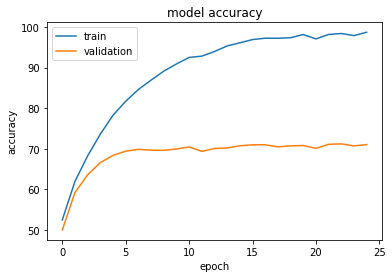

In [28]:
#  "Accuracy"
plt.plot(history['train_accuracy'])
plt.plot(history['validation_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

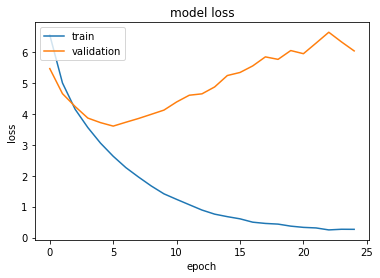

In [29]:
# "Loss"
plt.plot(history['train_losses'])
plt.plot(history['validation_losses'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
## Testing classification accuracy for individual classes. -- also it is useful if you want it
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Airplane : 76 %
Accuracy of   Car : 79 %
Accuracy of  Bird : 65 %
Accuracy of   Cat : 52 %
Accuracy of  Deer : 65 %
Accuracy of   Dog : 59 %
Accuracy of  Frog : 80 %
Accuracy of Horse : 70 %
Accuracy of  Ship : 86 %
Accuracy of Truck : 74 %
